## Imports

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device= 'cpu'
print(f"Using {device} device")

Using cpu device


## Leitura Dados

In [23]:
X = pd.read_csv('./2d/sr3/X_train.csv').drop(columns=['index', 'Unnamed: 0'])
y = pd.read_csv('./2d/sr3/y_train.csv').drop(columns=['index', 'Unnamed: 0'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_test = pd.read_csv('./2d_test/sr3/X_test.csv').drop(columns=['index', 'Unnamed: 0'])
y_test = pd.read_csv('./2d_test/sr3/y_test.csv').drop(columns=['index', 'Unnamed: 0'])


In [24]:
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

print('')
print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_train.shape}')

Train: 9665
Validation: 3222
Test: 1315

Input shape: (9665, 225)
Output shape: (9665, 175)


In [25]:
def df2tensor(df, ni, nj):
    t1 = torch.tensor(df.values)
    t2 = torch.reshape(t1, (len(df), -1, ni, nj))
    return t2.float()

In [26]:
X_train_t = df2tensor(X_train, 5, 5)
y_train_t = df2tensor(y_train, 5, 5)

X_val_t = df2tensor(X_val, 5, 5)
y_val_t = df2tensor(y_val, 5, 5)

X_test_t = df2tensor(X_test, 5, 5)
y_test_t = df2tensor(y_test, 5, 5)

In [27]:
sample = int(np.random.random()*len(X_train_t))
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in X_train.columns if c[-2:]=='_0']):
    print(c)
    print(X_train_t[sample][i])

Sample 4198
Por
tensor([[0.0970, 0.1460, 0.1400, 0.1090, 0.1020],
        [0.0950, 0.1250, 0.1550, 0.1170, 0.1070],
        [0.1080, 0.1100, 0.1400, 0.1490, 0.1350],
        [0.1340, 0.1010, 0.1340, 0.1640, 0.1450],
        [0.1440, 0.1410, 0.1510, 0.1900, 0.1630]])
PermI
tensor([[ 14.3000,  72.6000,  50.2000,  27.4000,  22.9000],
        [  8.6000,  68.2000, 165.7000,  20.6000,  23.2000],
        [ 16.5000,  36.2000,  97.1000, 106.5000,  34.5000],
        [ 35.2000,   8.8000,  50.5000,  95.7000,  40.1000],
        [ 98.8000,  57.2000,  68.0000, 111.3000,  88.2000]])
PermJ
tensor([[ 18.9000,  87.7000,  53.6000,  28.4000,  23.3000],
        [  9.8000, 126.5000, 166.9000,  28.2000,  27.7000],
        [ 17.7000,  47.6000,  95.7000, 114.6000,  43.8000],
        [ 28.7000,   8.8000,  59.1000,  98.2000,  58.2000],
        [ 94.7000,  42.9000,  65.0000, 254.1000, 118.1000]])
Pres
tensor([[377.4929, 417.5018, 425.5192, 431.0041, 434.6627],
        [409.2509, 423.7509, 429.5741, 435.0396, 438.4

In [28]:
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(y_train_t[sample][i])

Sample 4198
Pres
tensor([[377.3815, 417.3591, 425.3694, 430.8466, 434.5009],
        [409.1102, 423.6052, 429.4210, 434.8785, 438.2696],
        [427.0320, 429.1229, 434.5816, 439.0140, 441.8850],
        [434.8037, 436.2034, 439.8431, 442.7019, 445.5432],
        [438.1285, 440.2036, 442.4622, 444.8579, 448.4848]])
Sw
tensor([[0.1854, 0.1950, 0.2064, 0.1977, 0.1986],
        [0.1891, 0.2343, 0.2753, 0.2701, 0.2683],
        [0.1861, 0.2519, 0.3112, 0.3303, 0.3320],
        [0.1853, 0.2257, 0.3209, 0.3575, 0.3784],
        [0.2057, 0.2762, 0.3394, 0.3843, 0.4291]])
Kro
tensor([[0.2381, 0.2169, 0.1935, 0.2109, 0.2087],
        [0.2299, 0.1442, 0.0897, 0.0957, 0.0978],
        [0.2364, 0.1185, 0.0563, 0.0429, 0.0418],
        [0.2382, 0.1583, 0.0488, 0.0279, 0.0195],
        [0.1948, 0.0886, 0.0371, 0.0175, 0.0070]])
Krw
tensor([[0.0002, 0.0013, 0.0038, 0.0018, 0.0020],
        [0.0005, 0.0115, 0.0281, 0.0257, 0.0249],
        [0.0002, 0.0180, 0.0468, 0.0581, 0.0591],
        [0.0002, 0.

In [29]:
AA = torch.transpose(X_train_t, 0, 1)
AA = AA.reshape(AA.size(0), -1)

min_values, _ = AA.min(dim=1, keepdim=False)
print(f'Min.values: {min_values}')

max_values, _ = AA.max(dim=1, keepdim=False)
print(f'Max.values: {max_values}')

Min.values: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Max.values: tensor([2.3900e-01, 1.3911e+03, 1.4158e+03, 1.2237e+03, 5.6159e-01, 2.5000e-01,
        2.5735e-01, 1.2237e+03, 3.5000e+01])


In [30]:
def get_max_values(tensor):
    AA = torch.transpose(tensor, 0, 1)
    AA = AA.reshape(AA.size(0), -1)
    max_values, _ = AA.max(dim=1, keepdim=False)
    return max_values

In [31]:
max_values = get_max_values(X_train_t)
max_values_y = get_max_values(y_train_t)

In [32]:
def tensor2norm(tensor, max_values):
    AA = torch.transpose(tensor, 0, 1)
    AA = AA.reshape(AA.size(0), -1)
    AA = AA / max_values[:, None]
    AA = AA.reshape(AA.size(0), -1, 5, 5)
    return torch.transpose(AA, 0, 1)

def norm2tensor(tensor, max_values):
    AA = torch.transpose(tensor, 0, 1)
    AA = AA.reshape(AA.size(0), -1)
    AA = AA * max_values[:, None]
    AA = AA.reshape(AA.size(0), -1, 5, 5)
    return torch.transpose(AA, 0, 1)

In [33]:
X_train_t_norm = tensor2norm(X_train_t, max_values)
X_val_t_norm = tensor2norm(X_val_t, max_values)
X_test_t_norm = tensor2norm(X_test_t, max_values)

y_train_t_norm = tensor2norm(y_train_t, max_values_y)
y_val_t_norm = tensor2norm(y_val_t, max_values_y)
y_test_t_norm = tensor2norm(y_test_t, max_values_y)

In [34]:
norm2tensor(X_train_t_norm, max_values)[0][0]

tensor([[0.1670, 0.1160, 0.1080, 0.1190, 0.1210],
        [0.1170, 0.1140, 0.0840, 0.1010, 0.1230],
        [0.1210, 0.1000, 0.0990, 0.1150, 0.1130],
        [0.1220, 0.1200, 0.1150, 0.1360, 0.1390],
        [0.1400, 0.1380, 0.1070, 0.1450, 0.1470]])

In [35]:
X_train_t[0][0]

tensor([[0.1670, 0.1160, 0.1080, 0.1190, 0.1210],
        [0.1170, 0.1140, 0.0840, 0.1010, 0.1230],
        [0.1210, 0.1000, 0.0990, 0.1150, 0.1130],
        [0.1220, 0.1200, 0.1150, 0.1360, 0.1390],
        [0.1400, 0.1380, 0.1070, 0.1450, 0.1470]])

In [36]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (
            self.X[idx],
            self.y[idx]
        )
        return sample

In [37]:
data_train = CustomDataset(X_train_t_norm, y_train_t_norm)
data_val = CustomDataset(X_val_t_norm, y_val_t_norm)
data_test = CustomDataset(X_test_t_norm, y_test_t_norm)

In [38]:
batch_size = 16
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [39]:
for X,y in dataloader_val:
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([16, 9, 5, 5])
Output shape: torch.Size([16, 7, 5, 5])


## Neural Network

In [40]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, latent_size, max_size, recurrences):
        super(Network,self).__init__()
        self.enc_1 = nn.Conv2d(  input_size, 2*input_size, 1, padding=0)
        self.enc_2 = nn.Conv2d(2*input_size,  latent_size, 1, padding=0)
        # self.enc_3 = nn.Conv2d( latent_size,  latent_size, 1, padding=0)
        # self.enc_4 = nn.Conv2d( latent_size,  latent_size, 1, padding=0)

        self.proc_1 = nn.Conv2d(  latent_size, 2*latent_size, 3, padding=1)
        self.proc_2 = nn.Conv2d(2*latent_size,      max_size, 3, padding=1)
        # self.proc_3 = nn.Conv2d(     max_size,      max_size, 3, padding=1)
        # self.proc_4 = nn.Conv2d(     max_size,      max_size, 3, padding=1)
        self.proc_5 = nn.Conv2d(     max_size, 2*latent_size, 3, padding=1)
        self.proc_6 = nn.Conv2d(2*latent_size,   latent_size, 3, padding=1)

        # self.dec_1 = nn.Conv2d(  latent_size,   latent_size, 1, padding=0)
        self.dec_2 = nn.Conv2d(  latent_size, 2*output_size, 1, padding=0)
        self.dec_3 = nn.Conv2d(2*output_size,   output_size, 1, padding=0)
        # self.dec_4 = nn.Conv2d(  output_size,   output_size, 1, padding=0)
        # self.dec_5 = nn.Conv2d(  output_size,   output_size, 1, padding=0)

        self.recurrences = recurrences

    def forward(self, x):
        x = self.enc_1(x)
        x = F.relu(x)
        x = self.enc_2(x)
        x = F.relu(x)
        # x = self.enc_3(x)
        # x = F.relu(x)
        # x = self.enc_4(x)
        # x = F.relu(x)

        for _ in range(self.recurrences):
            residual = x
            x = self.proc_1(x)
            x = F.relu(x)
            x = self.proc_2(x)
            x = F.relu(x)
            # x = self.proc_3(x)
            # x = F.relu(x)
            # x = self.proc_4(x)
            # x = F.relu(x)
            x = self.proc_5(x)
            x = F.relu(x)
            x = self.proc_6(x)
            x += residual
            x = F.relu(x)

        # x = self.dec_1(x)
        # x = F.relu(x)
        x = self.dec_2(x)
        x = F.relu(x)
        x = self.dec_3(x)
        # x = F.relu(x)
        # x = self.dec_4(x)
        # x = F.relu(x)
        # x = self.dec_5(x)
        x = F.sigmoid(x)
        return x

In [41]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)

some_data = X_train_t_norm
print(f'Input: {some_data.shape}')
loss_fn = nn.MSELoss()
result = model(some_data)
print(f'Result: {result.shape}')

loss = loss_fn(result, y_train_t_norm)
loss.backward()
print(f'Loss = {loss:0.2f}')

Input: torch.Size([9665, 9, 5, 5])


Result: torch.Size([9665, 7, 5, 5])
Loss = 0.18


In [42]:
torch.onnx.export(model, X_test_t_norm, 'test.onnx', input_names=["features"], output_names=["results"])
# https://machinelearningmastery.com/visualizing-a-pytorch-model/
# https://netron.app/

In [43]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total += param.numel()
print(f'Total: {total}')

Layer: enc_1.weight | Parameters: 162
Layer: enc_1.bias | Parameters: 18
Layer: enc_2.weight | Parameters: 576
Layer: enc_2.bias | Parameters: 32
Layer: proc_1.weight | Parameters: 18432
Layer: proc_1.bias | Parameters: 64
Layer: proc_2.weight | Parameters: 36864
Layer: proc_2.bias | Parameters: 64
Layer: proc_5.weight | Parameters: 36864
Layer: proc_5.bias | Parameters: 64
Layer: proc_6.weight | Parameters: 18432
Layer: proc_6.bias | Parameters: 32
Layer: dec_2.weight | Parameters: 448
Layer: dec_2.bias | Parameters: 14
Layer: dec_3.weight | Parameters: 98
Layer: dec_3.bias | Parameters: 7
Total: 112171


## Ajuste

In [44]:
def plot_losses(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1,len(train_losses)+1), val_losses, label='Val')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Model Training")
    plt.legend()
    plt.grid(True)
    plt.show()

In [45]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        if verbose:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return float(torch.tensor(losses).mean())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def train(model: Network,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          scheduler=None,
          file_name='model.pth',
          verbose=False):

    model.to(device)

    best_val = np.inf
    train_loss = []
    val_loss = []
    print("=> Starting training")
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer, verbose))
        val_loss.append(test_loop(val_dataloader, model, loss_fn))
        star = ''
        if val_loss[-1]*1.01 < best_val:
            best_val = val_loss[-1]
            torch.save(model, file_name)
            star = '*'
        if scheduler is not None:
            scheduler.step(val_loss[-1])
        print(f' {t + 1}: train = {train_loss[-1]:0.4g}, val = {val_loss[-1]:0.4g}{star}, lr = {scheduler.get_last_lr()[0]}')
    print("Done!")
    best_model = torch.load(file_name)
    return best_model, (train_loss, val_loss)

=> Starting training
 1: train = 3.227e+04, val = 3.261e+04*
 2: train = 3.228e+04, val = 3.261e+04*
 3: train = 3.223e+04, val = 3.261e+04*
 4: train = 3.228e+04, val = 3.261e+04*
 5: train = 3.23e+04, val = 3.261e+04*
 6: train = 3.226e+04, val = 3.261e+04*
 7: train = 3.23e+04, val = 3.261e+04*
 8: train = 3.227e+04, val = 3.261e+04*
 9: train = 3.225e+04, val = 3.261e+04*
 10: train = 3.226e+04, val = 3.261e+04*
 11: train = 3.228e+04, val = 3.261e+04*
 12: train = 3.225e+04, val = 3.261e+04*
 13: train = 3.227e+04, val = 3.261e+04*
 14: train = 3.228e+04, val = 3.261e+04*
 15: train = 3.226e+04, val = 3.261e+04*
 16: train = 3.227e+04, val = 3.261e+04*
 17: train = 3.228e+04, val = 3.261e+04*
 18: train = 3.225e+04, val = 3.261e+04*
 19: train = 3.228e+04, val = 3.261e+04*
 20: train = 3.223e+04, val = 3.258e+04*
 21: train = 3.211e+04, val = 3.208e+04*
 22: train = 3.035e+04, val = 2.839e+04*
 23: train = 2.67e+04, val = 2.641e+04*
 24: train = 2.61e+04, val = 2.624e+04*
 25: tra

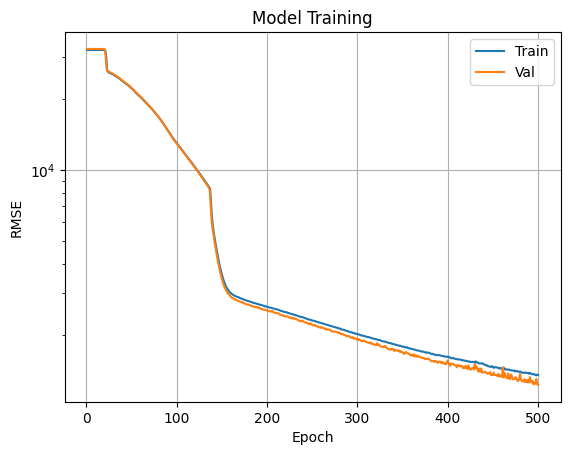

Test loss = 3084 (last model)
Test loss = 3084 (best model)


In [151]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.00001)  # ok
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)  # ok

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

In [55]:
data_val

=> Starting training
 1: train = 0.06365, val = 0.04899*, lr = 0.0001
 2: train = 0.04723, val = 0.04517*, lr = 0.0001
 3: train = 0.0438, val = 0.04241*, lr = 0.0001
 4: train = 0.04112, val = 0.03906*, lr = 0.0001
 5: train = 0.03626, val = 0.0331*, lr = 0.0001
 6: train = 0.03211, val = 0.03036*, lr = 0.0001
 7: train = 0.02953, val = 0.02998*, lr = 0.0001
 8: train = 0.02356, val = 0.01786*, lr = 0.0001
 9: train = 0.0185, val = 0.01639*, lr = 0.0001
 10: train = 0.01678, val = 0.01507*, lr = 0.0001
 11: train = 0.01564, val = 0.01674, lr = 0.0001
 12: train = 0.015, val = 0.01264*, lr = 0.0001
 13: train = 0.01415, val = 0.01239*, lr = 0.0001
 14: train = 0.01323, val = 0.01237, lr = 0.0001
 15: train = 0.01285, val = 0.01074*, lr = 0.0001
 16: train = 0.01192, val = 0.01055*, lr = 0.0001
 17: train = 0.01175, val = 0.009379*, lr = 0.0001
 18: train = 0.01102, val = 0.01067, lr = 0.0001
 19: train = 0.01067, val = 0.009073*, lr = 0.0001
 20: train = 0.01019, val = 0.008258*, lr = 

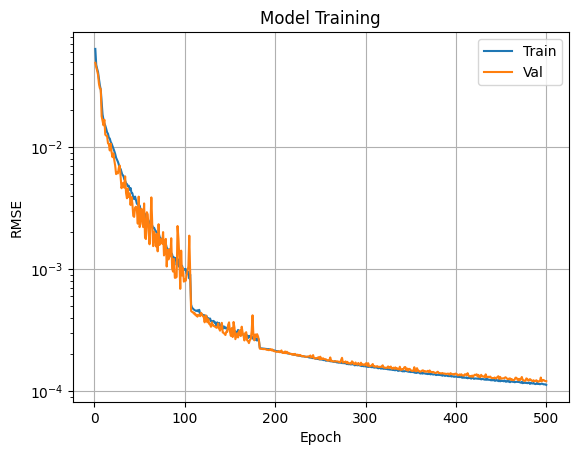

Test loss = 0.00393 (last model)
Test loss = 0.003928 (best model)


In [46]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=2)
loss_fn = nn.MSELoss()

alpha = 0.25

data_train = CustomDataset(X_train_t_norm[:int(len(X_train_t_norm)*alpha)], y_train_t_norm[:int(len(y_train_t_norm)*alpha)])
data_val = CustomDataset(X_val_t_norm[:int(len(X_val_t_norm)*alpha)], y_val_t_norm[:int(len(y_val_t_norm)*alpha)])
data_test = CustomDataset(X_test_t_norm, y_test_t_norm)

batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 0.0656, val = 0.03638*, lr = 0.0001
 2: train = 0.03089, val = 0.02757*, lr = 0.0001
 3: train = 0.02531, val = 0.03695, lr = 0.0001
 4: train = 0.015, val = 0.01277*, lr = 0.0001
 5: train = 0.01168, val = 0.009308*, lr = 0.0001
 6: train = 0.01125, val = 0.009922, lr = 0.0001
 7: train = 0.009751, val = 0.008191*, lr = 0.0001
 8: train = 0.00999, val = 0.007612*, lr = 0.0001
 9: train = 0.00928, val = 0.008286, lr = 0.0001
 10: train = 0.008903, val = 0.008037, lr = 0.0001
 11: train = 0.008733, val = 0.007256*, lr = 0.0001
 12: train = 0.008445, val = 0.007014*, lr = 0.0001
 13: train = 0.008211, val = 0.007418, lr = 0.0001
 14: train = 0.007995, val = 0.007131, lr = 0.0001
 15: train = 0.008101, val = 0.006901*, lr = 0.0001
 16: train = 0.007375, val = 0.007893, lr = 0.0001
 17: train = 0.00765, val = 0.006613*, lr = 0.0001
 18: train = 0.006971, val = 0.005455*, lr = 0.0001
 19: train = 0.006823, val = 0.006459, lr = 0.0001
 20: train = 0.006815, v

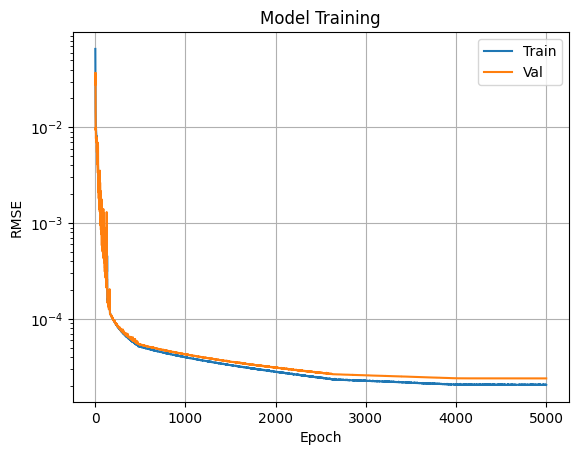

Test loss = 0.002583 (last model)
Test loss = 0.002584 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=2)
loss_fn = nn.MSELoss()

alpha = 0.25

data_train = CustomDataset(X_train_t_norm[:int(len(X_train_t_norm)*alpha)], y_train_t_norm[:int(len(y_train_t_norm)*alpha)])
data_val = CustomDataset(X_val_t_norm[:int(len(X_val_t_norm)*alpha)], y_val_t_norm[:int(len(y_val_t_norm)*alpha)])
data_test = CustomDataset(X_test_t_norm, y_test_t_norm)

batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 5000
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 0.0747, val = 0.04982*, lr = 0.0001
 2: train = 0.04774, val = 0.04551*, lr = 0.0001
 3: train = 0.0448, val = 0.04366*, lr = 0.0001
 4: train = 0.04303, val = 0.04189*, lr = 0.0001
 5: train = 0.04143, val = 0.04072*, lr = 0.0001
 6: train = 0.04009, val = 0.03908*, lr = 0.0001
 7: train = 0.03876, val = 0.03782*, lr = 0.0001
 8: train = 0.03755, val = 0.03671*, lr = 0.0001
 9: train = 0.03657, val = 0.036*, lr = 0.0001
 10: train = 0.03548, val = 0.03443*, lr = 0.0001
 11: train = 0.03441, val = 0.03381*, lr = 0.0001
 12: train = 0.03376, val = 0.03278*, lr = 0.0001
 13: train = 0.03295, val = 0.03206*, lr = 0.0001
 14: train = 0.03225, val = 0.03128*, lr = 0.0001
 15: train = 0.0316, val = 0.03054*, lr = 0.0001
 16: train = 0.03096, val = 0.03015*, lr = 0.0001
 17: train = 0.03052, val = 0.02965*, lr = 0.0001
 18: train = 0.03006, val = 0.02929*, lr = 0.0001
 19: train = 0.02958, val = 0.02848*, lr = 0.0001
 20: train = 0.02923, val = 0.028*, lr = 0.

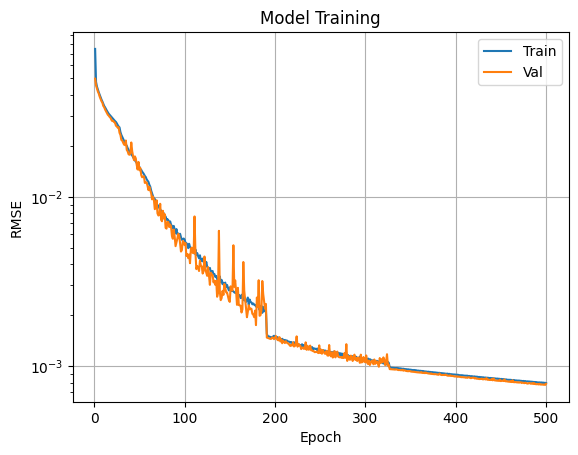

Test loss = 0.006981 (last model)
Test loss = 0.006961 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 0.208, val = 0.1887*, lr = 0.0001
 2: train = 0.1801, val = 0.1758*, lr = 0.0001
 3: train = 0.1684, val = 0.1643*, lr = 0.0001
 4: train = 0.1584, val = 0.1543*, lr = 0.0001
 5: train = 0.1496, val = 0.1453*, lr = 0.0001
 6: train = 0.1414, val = 0.1371*, lr = 0.0001
 7: train = 0.1332, val = 0.1295*, lr = 0.0001
 8: train = 0.126, val = 0.1228*, lr = 0.0001
 9: train = 0.1189, val = 0.1171*, lr = 0.0001
 10: train = 0.1126, val = 0.1102*, lr = 0.0001
Done!


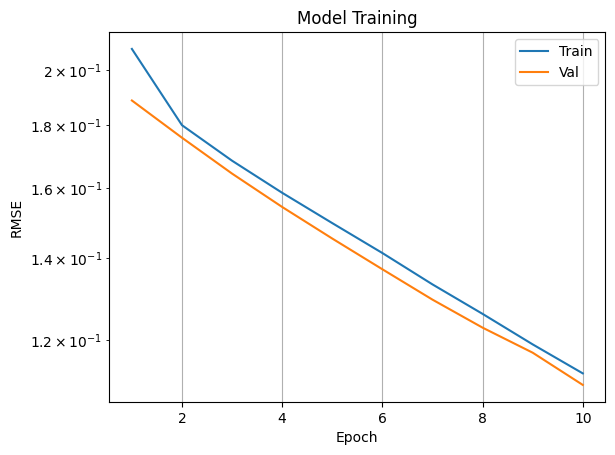

Test loss = 0.09496 (last model)
Test loss = 0.09496 (best model)


In [256]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 10
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 3.165e+04, val = 3.101e+04*, lr = 0.0001
 2: train = 3.049e+04, val = 3.056e+04*, lr = 0.0001
 3: train = 3.007e+04, val = 3.012e+04*, lr = 0.0001
 4: train = 2.958e+04, val = 2.955e+04*, lr = 0.0001
 5: train = 2.904e+04, val = 2.914e+04*, lr = 0.0001
 6: train = 2.837e+04, val = 2.811e+04*, lr = 0.0001
 7: train = 2.764e+04, val = 2.742e+04*, lr = 0.0001
 8: train = 2.683e+04, val = 2.681e+04*, lr = 0.0001
 9: train = 2.586e+04, val = 2.577e+04*, lr = 0.0001
 10: train = 2.484e+04, val = 2.554e+04*, lr = 0.0001
 11: train = 2.383e+04, val = 2.356e+04*, lr = 0.0001
 12: train = 2.287e+04, val = 2.26e+04*, lr = 0.0001
 13: train = 2.185e+04, val = 2.144e+04*, lr = 0.0001
 14: train = 2.094e+04, val = 2.057e+04*, lr = 0.0001
 15: train = 1.987e+04, val = 1.921e+04*, lr = 0.0001
 16: train = 1.887e+04, val = 1.823e+04*, lr = 0.0001
 17: train = 1.781e+04, val = 1.721e+04*, lr = 0.0001
 18: train = 1.667e+04, val = 1.582e+04*, lr = 0.0001
 19: train = 1.55

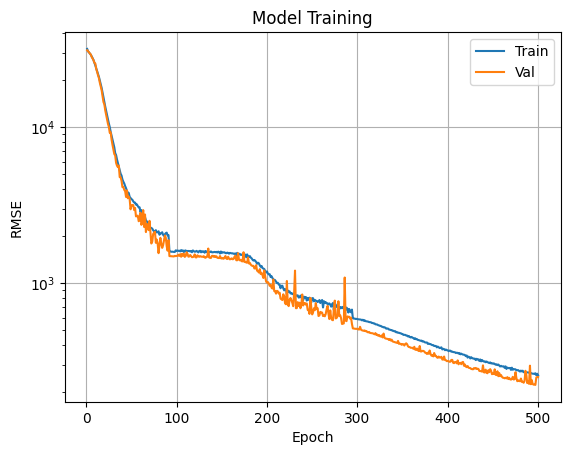

Test loss = 3699 (last model)
Test loss = 3592 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 2.939e+04, val = 2.459e+04*, lr = 0.0001
 2: train = 1.88e+04, val = 2.053e+04*, lr = 0.0001
 3: train = 1.816e+04, val = 1.488e+04*, lr = 0.0001
 4: train = 1.695e+04, val = 1.527e+04, lr = 0.0001
 5: train = 1.614e+04, val = 1.306e+04*, lr = 0.0001
 6: train = 1.65e+04, val = 2.643e+04, lr = 0.0001
 7: train = 1.473e+04, val = 1.13e+04*, lr = 0.0001
 8: train = 1.379e+04, val = 1.107e+04*, lr = 0.0001
 9: train = 1.169e+04, val = 9138*, lr = 0.0001
 10: train = 1.257e+04, val = 9043*, lr = 0.0001
 11: train = 1.125e+04, val = 6658*, lr = 0.0001
 12: train = 1.018e+04, val = 9262, lr = 0.0001
 13: train = 9314, val = 5624*, lr = 0.0001
 14: train = 9442, val = 8396, lr = 0.0001
 15: train = 9234, val = 6175, lr = 0.0001
 16: train = 7955, val = 7019, lr = 0.0001
 17: train = 8086, val = 4346*, lr = 0.0001
 18: train = 7595, val = 1.304e+04, lr = 0.0001
 19: train = 7127, val = 4860, lr = 0.0001
 20: train = 7083, val = 4998, lr = 0.0001
 21: train = 72

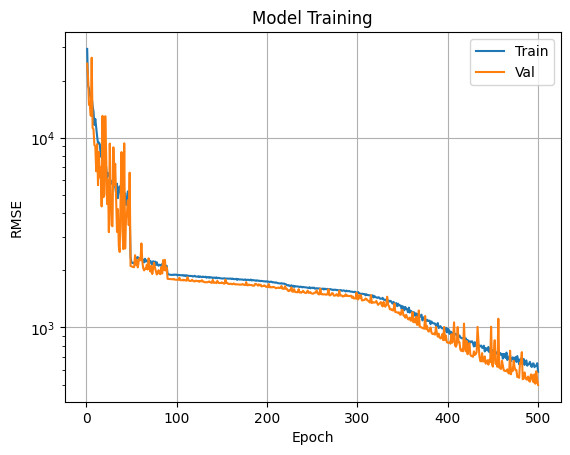

Test loss = 3127 (last model)
Test loss = 3127 (best model)


In [166]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=64,
    max_size=128,
    recurrences=5)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.25, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 3.16e+04, val = 2.595e+04*, lr = [0.0001]
 2: train = 2.525e+04, val = 2.51e+04*, lr = [0.0001]
 3: train = 2.444e+04, val = 2.414e+04*, lr = [0.0001]
 4: train = 2.339e+04, val = 2.296e+04*, lr = [0.0001]
 5: train = 2.212e+04, val = 2.163e+04*, lr = [0.0001]
 6: train = 2.083e+04, val = 2.028e+04*, lr = [0.0001]
 7: train = 1.937e+04, val = 1.903e+04*, lr = [0.0001]
 8: train = 1.852e+04, val = 1.744e+04*, lr = [0.0001]
 9: train = 1.686e+04, val = 1.63e+04*, lr = [0.0001]
 10: train = 1.539e+04, val = 1.452e+04*, lr = [0.0001]
 11: train = 1.4e+04, val = 1.662e+04, lr = [0.0001]
 12: train = 1.228e+04, val = 1.11e+04*, lr = [0.0001]
 13: train = 1.11e+04, val = 1.305e+04, lr = [0.0001]
 14: train = 1.013e+04, val = 8990*, lr = [0.0001]
 15: train = 8897, val = 8365*, lr = [0.0001]
 16: train = 8054, val = 6933*, lr = [0.0001]
 17: train = 7411, val = 6753*, lr = [0.0001]
 18: train = 6733, val = 5334*, lr = [0.0001]
 19: train = 6056, val = 5063*, lr

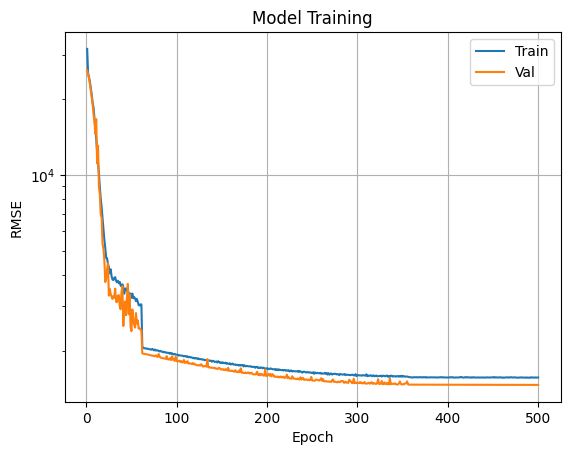

Test loss = 3182 (last model)
Test loss = 3182 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=32,
    recurrences=5)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.1, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 2.788e+04, val = 2.292e+04*, lr = [0.0001]
 2: train = 2.179e+04, val = 2.098e+04*, lr = [0.0001]
 3: train = 2.001e+04, val = 1.912e+04*, lr = [0.0001]
 4: train = 1.79e+04, val = 1.627e+04*, lr = [0.0001]
 5: train = 1.521e+04, val = 1.38e+04*, lr = [0.0001]
 6: train = 1.277e+04, val = 1.161e+04*, lr = [0.0001]
 7: train = 1.07e+04, val = 9681*, lr = [0.0001]
 8: train = 8926, val = 7870*, lr = [0.0001]
 9: train = 7634, val = 6496*, lr = [0.0001]
 10: train = 6467, val = 5611*, lr = [0.0001]
 11: train = 5445, val = 4672*, lr = [0.0001]
 12: train = 4869, val = 4495*, lr = [0.0001]
 13: train = 4438, val = 3816*, lr = [0.0001]
 14: train = 4074, val = 3836, lr = [0.0001]
 15: train = 3840, val = 3837, lr = [0.0001]
 16: train = 3655, val = 3215*, lr = [0.0001]
 17: train = 3408, val = 3204*, lr = [0.0001]
 18: train = 3223, val = 2719*, lr = [0.0001]
 19: train = 3176, val = 2747, lr = [0.0001]
 20: train = 2951, val = 2832, lr = [0.0001]
 21: train

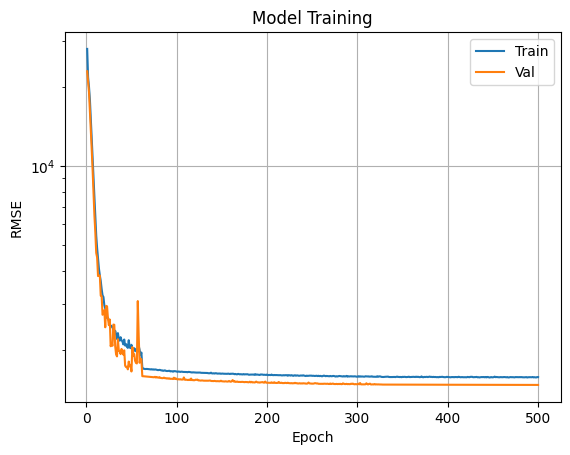

Test loss = 3217 (last model)
Test loss = 3217 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=16,
    max_size=32,
    recurrences=3)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.1, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 1.325e+05, val = 2.716e+04*
 2: train = 1.945e+04, val = 1.799e+04*
 3: train = 1.645e+04, val = 1.487e+04*
 4: train = 1.268e+04, val = 9687*
 5: train = 8535, val = 7080*
 6: train = 6008, val = 4280*
 7: train = 4026, val = 3272*
 8: train = 3372, val = 3121*
 9: train = 3139, val = 4567
 10: train = 2954, val = 2987*
 11: train = 2799, val = 2430*
 12: train = 2691, val = 2847
 13: train = 2772, val = 3149
 14: train = 2681, val = 2731
 15: train = 2627, val = 3892
 16: train = 2774, val = 2308*
 17: train = 2747, val = 2692
 18: train = 2975, val = 2580
 19: train = 2994, val = 4045
 20: train = 3223, val = 6328
 21: train = 3440, val = 2783
 22: train = 3338, val = 3760
 23: train = 3565, val = 4157
 24: train = 3640, val = 5201
 25: train = 3833, val = 4264
 26: train = 3349, val = 3742
 27: train = 3650, val = 2012*
 28: train = 3353, val = 2353
 29: train = 3913, val = 1939*
 30: train = 3728, val = 5784
 31: train = 3706, val = 5493
 32: train

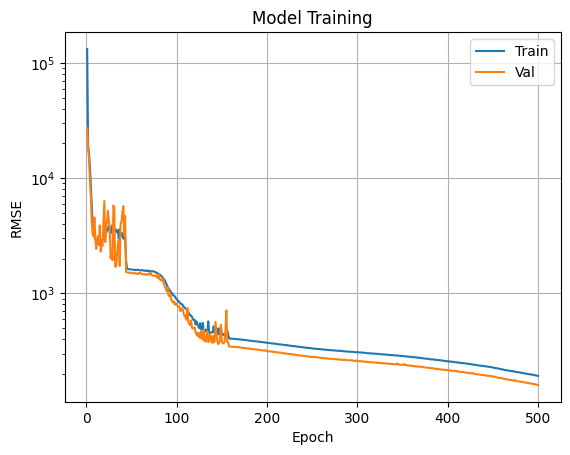

Test loss = 2903 (last model)
Test loss = 2903 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.1, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 2.627e+04, val = 1.958e+04*
 2: train = 1.846e+04, val = 1.776e+04*
 3: train = 1.688e+04, val = 1.612e+04*
 4: train = 1.514e+04, val = 1.435e+04*
 5: train = 1.356e+04, val = 1.298e+04*
 6: train = 1.232e+04, val = 1.177e+04*
 7: train = 1.123e+04, val = 1.058e+04*
 8: train = 1.021e+04, val = 1.022e+04*
 9: train = 9363, val = 8780*
 10: train = 8461, val = 7984*
 11: train = 7758, val = 7138*
 12: train = 7123, val = 6638*
 13: train = 6553, val = 6504*
 14: train = 6028, val = 5988*
 15: train = 5594, val = 5016*
 16: train = 5080, val = 5232
 17: train = 4707, val = 4187*
 18: train = 4412, val = 4288
 19: train = 4156, val = 4258
 20: train = 3847, val = 3681*
 21: train = 3627, val = 3571*
 22: train = 3540, val = 3565*
 23: train = 3343, val = 3222*
 24: train = 3356, val = 3314
 25: train = 3238, val = 3078*
 26: train = 3210, val = 3144
 27: train = 3179, val = 3459
 28: train = 3191, val = 2959*
 29: train = 3088, val = 3373
 30: train = 306

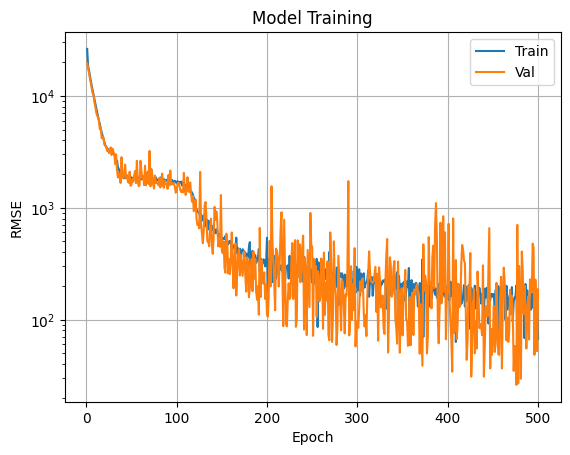

Test loss = 2906 (last model)
Test loss = 2813 (best model)


In [ ]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 20
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)  # ok
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)  # ok

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

### Sample test

In [47]:
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(y_train_t[sample][i])

Sample 4198
Pres
tensor([[377.3815, 417.3591, 425.3694, 430.8466, 434.5009],
        [409.1102, 423.6052, 429.4210, 434.8785, 438.2696],
        [427.0320, 429.1229, 434.5816, 439.0140, 441.8850],
        [434.8037, 436.2034, 439.8431, 442.7019, 445.5432],
        [438.1285, 440.2036, 442.4622, 444.8579, 448.4848]])
Sw
tensor([[0.1854, 0.1950, 0.2064, 0.1977, 0.1986],
        [0.1891, 0.2343, 0.2753, 0.2701, 0.2683],
        [0.1861, 0.2519, 0.3112, 0.3303, 0.3320],
        [0.1853, 0.2257, 0.3209, 0.3575, 0.3784],
        [0.2057, 0.2762, 0.3394, 0.3843, 0.4291]])
Kro
tensor([[0.2381, 0.2169, 0.1935, 0.2109, 0.2087],
        [0.2299, 0.1442, 0.0897, 0.0957, 0.0978],
        [0.2364, 0.1185, 0.0563, 0.0429, 0.0418],
        [0.2382, 0.1583, 0.0488, 0.0279, 0.0195],
        [0.1948, 0.0886, 0.0371, 0.0175, 0.0070]])
Krw
tensor([[0.0002, 0.0013, 0.0038, 0.0018, 0.0020],
        [0.0005, 0.0115, 0.0281, 0.0257, 0.0249],
        [0.0002, 0.0180, 0.0468, 0.0581, 0.0591],
        [0.0002, 0.

In [48]:
print(f'Sample {sample}')
pred_sample = best_model(X_train_t_norm[sample])

pred_sample_ = norm2tensor(pred_sample.unsqueeze(0), max_values_y)

for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(pred_sample_[0][i])

Sample 4198
Pres
tensor([[407.7733, 424.5078, 379.6160, 449.0603, 433.3483],
        [410.9293, 399.6202, 432.0148, 430.4743, 439.4929],
        [418.6766, 421.8373, 456.7953, 445.2071, 431.8857],
        [416.6384, 417.0563, 438.6479, 427.6688, 426.9624],
        [443.0085, 425.7871, 434.6698, 435.5891, 435.6948]],
       grad_fn=<SelectBackward0>)
Sw
tensor([[0.1900, 0.1963, 0.1990, 0.2093, 0.1831],
        [0.1909, 0.2256, 0.2871, 0.2728, 0.2675],
        [0.1882, 0.2479, 0.3124, 0.3284, 0.3336],
        [0.1742, 0.2348, 0.3197, 0.3566, 0.3762],
        [0.2043, 0.2707, 0.3397, 0.3895, 0.4320]], grad_fn=<SelectBackward0>)
Kro
tensor([[0.2361, 0.2225, 0.1987, 0.2138, 0.2105],
        [0.2308, 0.1438, 0.0792, 0.0864, 0.1008],
        [0.2322, 0.1278, 0.0529, 0.0450, 0.0408],
        [0.2351, 0.1438, 0.0543, 0.0297, 0.0202],
        [0.2102, 0.0950, 0.0376, 0.0170, 0.0072]], grad_fn=<SelectBackward0>)
Krw
tensor([[0.0022, 0.0044, 0.0047, 0.0045, 0.0051],
        [0.0021, 0.0085, 0.0295

## Teste Recorrência

In [49]:
import sys
sys.path.insert(0, '../python')
from simpython.cmg import sr3reader
import read_sr3

In [50]:
sim_days = 365*5
sim_number = 19

file_name = f'./2d_test/sr3/sens_{sim_number}.sr3'

In [51]:
sr3 = sr3reader.Sr3Reader(file_name)
sr3_data = read_sr3.read_data(sr3, days=[1])

Pwf_prod = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='P01',
    days=range(1, sim_days))

Np_prod = sr3.get_data(
    element_type='well',
    property_names='NP',
    element_names='P01',
    days=range(1, sim_days))

Qo_prod = sr3.get_data(
    element_type='well',
    property_names='QO',
    element_names='P01',
    days=range(1, sim_days))

Wp_prod = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='P01',
    days=range(1, sim_days))

Qw_prod = sr3.get_data(
    element_type='well',
    property_names='QW',
    element_names='P01',
    days=range(1, sim_days))

Pwf_inj = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='I01',
    days=range(1, sim_days))

Wp_inj = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='I01',
    days=range(1, sim_days))

Qw_inj = sr3.get_data(
    element_type='well',
    property_names='QW',
    element_names='I01',
    days=range(1, sim_days))

In [52]:
wells = {'P01':0, 'I01':24}
sim_data = read_sr3.organize_data(sr3_data[0], wells)

t1 = torch.tensor(sim_data['in'])
t2 = torch.reshape(t1, (-1, 5, 5))
sim_data_t = t2.float()
sim_data_t = sim_data_t

In [53]:
[c[:-2] for c in X_train.columns if c[-2:]=='_0']

['Por', 'PermI', 'PermJ', 'Pres', 'Sw', 'Kro', 'Krw', 'Pwf', 'QwI']

In [54]:
[c[:-2] for c in y_train.columns if c[-2:]=='_0']

['Pres', 'Sw', 'Kro', 'Krw', 'Qo', 'Qw', 'PwfI']

In [55]:
def value2map(value, position):
    array_ = np.zeros(25)
    array_[position] = value
    t1_ = torch.tensor(array_)
    t2_ = torch.reshape(t1_, (-1, 5, 5))
    return t2_.float()

In [56]:
Qo_nn = []
Qw_nn = []
Pwf_inj_nn = []
# current_state = sim_data_t.clone()
current_state = tensor2norm(sim_data_t.unsqueeze(0), max_values)[0]

for i in range(1,sim_days-1):

    pred = best_model(current_state)
    pred_ = norm2tensor(pred.unsqueeze(0), max_values_y)[0]

    Qo_nn.append(float(pred_[4][0][0]))
    Qw_nn.append(float(pred_[5][0][0]))
    Pwf_inj_nn.append(float(pred_[6][4][4]))

    stat_data = sim_data_t[0:3]
    new_state = pred_[0:4]
    control_Pwf = value2map((Pwf_prod[i,1]+Pwf_prod[i-1,1])/2, 0)
    control_Qwi = value2map(Wp_inj[i,1]-Wp_inj[i-1,1], 24)

    current_state = torch.cat((stat_data, new_state, control_Pwf, control_Qwi), dim=0)
    current_state = tensor2norm(current_state.unsqueeze(0), max_values)[0]

In [57]:
def plot_time_series(ts1, ts2=None, label1='1', label2='2', title=None):
    plt.plot(ts1, label=label1)
    if ts2 is not None:
        plt.plot(ts2, label=label2)
    plt.xlabel("days")
    # plt.ylabel("-")
    if title is not None:
        plt.title(title)
    if ts2 is not None:
        plt.legend()
    plt.grid(True)
    plt.show()

In [58]:
Qwi_nn = []
Pwf_prod_nn = []
for i in range(1,sim_days-1):
    Qwi_nn.append(Wp_inj[i,1]-Wp_inj[i-1,1])
    Pwf_prod_nn.append((Pwf_prod[i,1]+Pwf_prod[i-1,1])/2)

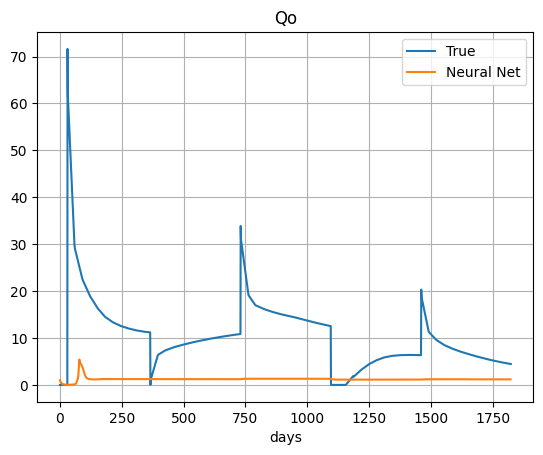

In [59]:
plot_time_series(Qo_prod[:,1], Qo_nn[:], label1="True", label2="Neural Net", title="Qo")

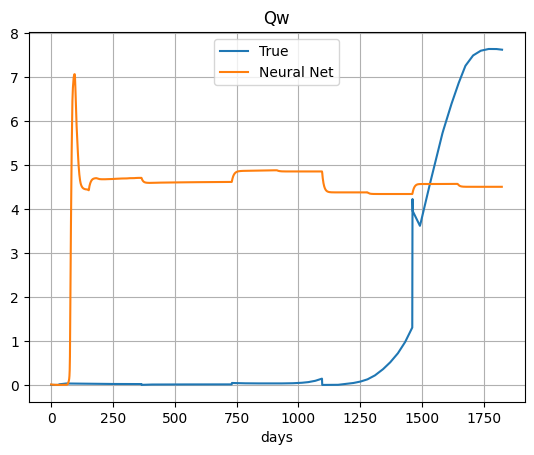

In [60]:
plot_time_series(Qw_prod[:,1], Qw_nn[:], label1="True", label2="Neural Net", title="Qw")

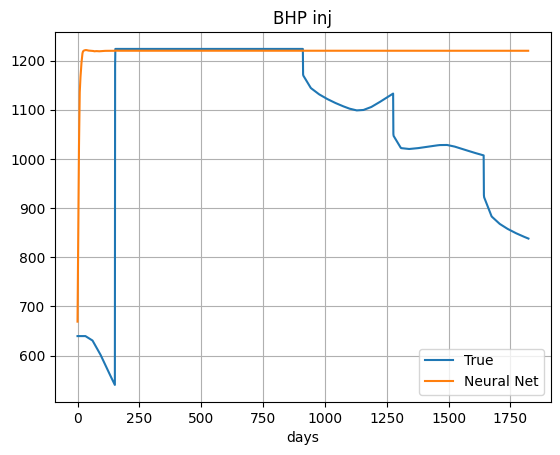

In [61]:
plot_time_series(Pwf_inj[:,1], Pwf_inj_nn[:], label1="True", label2="Neural Net", title="BHP inj")

In [62]:
# plot_time_series(Pwf_inj[:,1])
# plot_time_series(Wp_inj[:,1])
# plot_time_series(Pwf_prod[:,1])
# plot_time_series(Np_prod[:,1], Wp_prod[:,1])

## Notas

* Dados
    * Adicionar ruído aos dados.
    * Entrar Pwf 'qualquer' nas demais células?

* Resultados
    * Modelos maiores (mais parâmetros) tem conseguido melhores resultados no ajuste.
    * Erro no dados de teste não parece descer muito.
    * É preciso fazer uma sensibilidade do número de recorrências.
        * Um valor alto parece levar a mais instabilidade.

* Modelagem
    * Normalizar saída também para melhorar RSME.
        * Pensar em ajudar com variáveis que não tem valores negativos.
    * Criar 'escadinha' do número de filtros por camada.
    * Entrar número de camadas em cada etapa como hiperparâmetro.
    * Usar poços fantasma fechados para ter mapa de Pwf prod e inj.
        * Ajustar profundidade de referência.
    * Pesquisar early stopping